## Observations
1. Our gradient estimates at known sample locations are large when we resample at the sample location in our trajectory.

In [1]:
using LinearAlgebra
using Plots
using Random

In [2]:
include("../rollout.jl")
include("../testfns.jl")
include("../utils.jl")

stochastic_gradient_ascent_adam (generic function with 1 method)

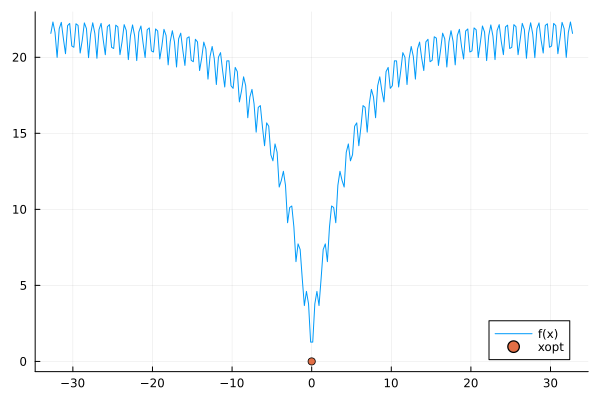

In [28]:
# testfn = TestLinearCosine1D(1, 25, lb=0., ub=2)
# testfn = TestQuadratic1D(1., 0., 0.; lb=-1., ub=1.)
# testfn = TestConstant(0., lbs=[-1.], ubs=[1.])
# testfn = TestGramacyLee()
# testfn = TestRosenbrock()
testfn = TestAckley(1)
tplot(testfn)

In [36]:
# Parameters
NUMBER_OF_STARTS = 8
NUMBER_OF_TRIALS = 1
BUDGET = 15
HORIZON = 1
MC_SAMPLES = 25
SHOULD_OPTIMIZE = false
BATCH_SIZE = 8

# Gaussian process hyperparameters
θ, σn2 = [1.], 1e-6
ψ = kernel_matern52(θ)

# Build the test function object
lbs, ubs = testfn.bounds[:,1], testfn.bounds[:,2]

Xinit = [-17.045395779826606;; -1.4725923478945515;;]
yinit = testfn.f.(eachcol(Xinit))
sur = fit_surrogate(ψ, Xinit, yinit; σn2=σn2)
sur = optimize_hypers_optim(sur, kernel_matern52)

RBFsurrogate(RBFfun([1.0], var"#ψ#443"{var"#k#453", Vector{Float64}}(var"#k#453"(), [1.0]), var"#Dρ_ψ#444"{var"#ψ#443"{var"#k#453", Vector{Float64}}}(var"#ψ#443"{var"#k#453", Vector{Float64}}(var"#k#453"(), [1.0])), var"#Dρρ_ψ#445"{var"#Dρ_ψ#444"{var"#ψ#443"{var"#k#453", Vector{Float64}}}}(var"#Dρ_ψ#444"{var"#ψ#443"{var"#k#453", Vector{Float64}}}(var"#ψ#443"{var"#k#453", Vector{Float64}}(var"#k#453"(), [1.0]))), var"#∇θ_ψ#446"{var"#k#453", Vector{Float64}}(var"#k#453"(), [1.0])), [-17.045395779826606 -1.4725923478945515], [1.000001 3.3153194833684874e-13; 3.3153194833684874e-13 1.000001], [1.000000499999875 0.0; 3.315317825709989e-13 1.000000499999875], [5.99954409077079, -5.999544090770788], [5.999538091234687, -5.999538091234685], 1.0e-6, 13.446660935041141)

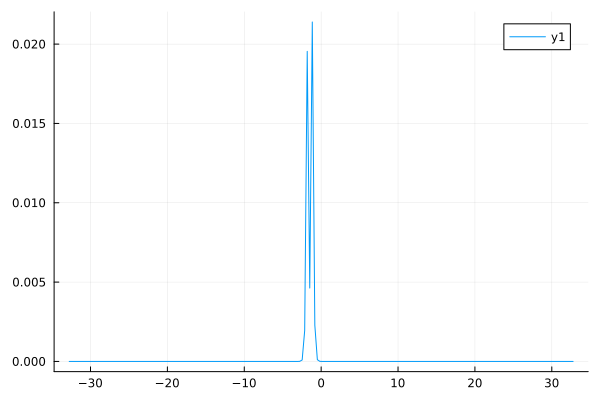

In [39]:
domain = range(lbs[1], ubs[1], length=200)
plot(domain, [sur([x]).EI for x in domain])

In [6]:
function poi_solver(s::RBFsurrogate, lbs, ubs; initial_guesses, max_iterations=100)
    fbest = minimum(get_observations(s))

    function poi(x)
        sx = s(x)
        if sx.σ < 1e-6 return 0 end
        return -cdf(Normal(), (fbest - sx.μ) / sx.σ)
    end

    final_minimizer = (initial_guesses[:, 1], Inf)
    
    for j in 1:size(initial_guesses, 2)
        initial_guess = initial_guesses[:, j]
        result = optimize(poi, lbs, ubs, initial_guess, Fminbox(LBFGS()), Optim.Options(iterations=max_iterations))
        cur_minimizer, cur_minimum = Optim.minimizer(result), Optim.minimum(result)

        if cur_minimum < final_minimizer[2]
            final_minimizer = (cur_minimizer, cur_minimum)
        end
    end
    
    return final_minimizer
end

function ei_solver(s::RBFsurrogate, lbs, ubs; initial_guesses, max_iterations=100)
    fbest = minimum(get_observations(s))

    function ei(x)
        sx = s(x)
        if sx.σ < 1e-6 return 0 end
        return -sx.EI
    end

    function ei_grad!(g, x)
        EIx = -s(x).∇EI
        for i in eachindex(EIx)
            g[i] = EIx[i]
        end
    end

    function ei_hessian!(h, x)
        HEIx = -s(x).HEI
        for row in 1:size(HEIx, 1)
            for col in 1:size(HEIx, 2)
                h[row, col] = HEIx[row, col]
            end
        end
    end

    final_minimizer = (initial_guesses[:, 1], Inf)
    
    for j in 1:size(initial_guesses, 2)
        initial_guess = initial_guesses[:, j]
        df = TwiceDifferentiable(ei, ei_grad!, ei_hessian!, initial_guess)
        dfc = TwiceDifferentiableConstraints(lbs, ubs)
        result = optimize(df, dfc, initial_guess, IPNewton(), Optim.Options(iterations=max_iterations))
        cur_minimizer, cur_minimum = Optim.minimizer(result), Optim.minimum(result)

        if cur_minimum < final_minimizer[2]
            final_minimizer = (cur_minimizer, cur_minimum)
        end
    end
    
    return final_minimizer
end

function ucb_solver(s::RBFsurrogate, lbs, ubs; initial_guesses, β=3., max_iterations=100)
    fbest = minimum(get_observations(s))

    function ucb(x)
        sx = s(x)
        return -(sx.μ + β*sx.σ)
    end

    final_minimizer = (initial_guesses[:, 1], Inf)
    
    for j in 1:size(initial_guesses, 2)
        initial_guess = initial_guesses[:, j]
        result = optimize(ucb, lbs, ubs, initial_guess, Fminbox(LBFGS()), Optim.Options(iterations=max_iterations))
        cur_minimizer, cur_minimum = Optim.minimizer(result), Optim.minimum(result)

        if cur_minimum < final_minimizer[2]
            final_minimizer = (cur_minimizer, cur_minimum)
        end
    end
    
    return final_minimizer
end

function rollout_solver(;
    sur::RBFsurrogate,
    tp::TrajectoryParameters,
    xstarts::Matrix{Float64},
    batch::Matrix{Float64},
    max_iterations::Int = 100,
    varred::Bool = true,
    )
    batch_results = Array{Any, 1}(undef, size(batch, 2))

    for i in 1:size(batch, 2)
        # Update start of trajectory for each point in the batch
        tp.x0 = batch[:, i]

        # Perform stochastic gradient ascent on the point in the batch
        batch_results[i] = stochastic_gradient_ascent_adam(
            sur=sur,
            tp=tp,
            max_sgd_iters=max_iterations,
            varred=varred,
            xstarts=xstarts,
        )
    end

    # Find the point in the batch that maximizes the rollout acquisition function
    best_tuple = first(batch_results)
    for result in batch_results[2:end]
        if result.final_obj > best_tuple.final_obj
            best_tuple = result
        end
    end

    return best_tuple.finish, best_tuple.final_obj
end

rollout_solver (generic function with 1 method)

In [9]:
function generate_initial_guesses(N::Int, lbs::Vector{T}, ubs::Vector{T},) where T <: Number
    ϵ = 1e-6
    seq = SobolSeq(lbs, ubs)
    initial_guesses = reduce(hcat, next!(seq) for i = 1:N)
    initial_guesses = hcat(initial_guesses, lbs .+ ϵ)
    initial_guesses = hcat(initial_guesses, ubs .- ϵ)

    return initial_guesses
end

function measure_gap(observations::Vector{T}, fbest::T) where T <: Number
    ϵ = 1e-8
    initial_minimum = observations[1]
    subsequent_minimums = [
        minimum(observations[1:j]) for j in 1:length(observations)
    ]
    numerator = initial_minimum .- subsequent_minimums
    
    if abs(fbest - initial_minimum) < ϵ
        return 1. 
    end
    
    denominator = initial_minimum - fbest
    result = numerator ./ denominator

    for i in 1:length(result)
        if result[i] < ϵ
            result[i] = 0
        end
    end

    return result
end

measure_gap (generic function with 1 method)

# Rollout vs Non-Rollout

In [19]:
# Parameters
NUMBER_OF_STARTS = 8
NUMBER_OF_TRIALS = 1
BUDGET = 15
HORIZON = 1
MC_SAMPLES = 25
SHOULD_OPTIMIZE = false
BATCH_SIZE = 8

# Gaussian process hyperparameters
θ, σn2 = [1.], 1e-6
ψ = kernel_matern52(θ)

# Build the test function object
lbs, ubs = testfn.bounds[:,1], testfn.bounds[:,2]

# Generate low discrepancy sequence
lds_rns = gen_low_discrepancy_sequence(MC_SAMPLES, testfn.dim, HORIZON + 1)

# Allocate initial guesses for optimizer
initial_guesses = generate_initial_guesses(NUMBER_OF_STARTS, lbs, ubs)

# Allocate all initial samples
initial_samples = randsample(NUMBER_OF_TRIALS, testfn.dim, lbs, ubs)

# Allocate space for GAPS
rollout_gaps = zeros(BUDGET + 1)
ei_gaps = zeros(BUDGET + 1)
ucb_gaps = zeros(BUDGET + 1)
poi_gaps = zeros(BUDGET + 1)

# Initialize the trajectory parameters
tp = TrajectoryParameters(
    initial_samples[:, 1], # Will be overriden later
    HORIZON,
    MC_SAMPLES,
    lds_rns,
    lbs,
    ubs,
)

# Initialize batch of points to evaluate the rollout acquisition function
batch = generate_batch(BATCH_SIZE, lbs=tp.lbs, ubs=tp.ubs)
sur = nothing
sur_ei = nothing
sur_poi = nothing
sur_ucb = nothing

for trial in 1:NUMBER_OF_TRIALS
    println("Executing Trial #$trial")
    # Initialize surrogate model
    Xinit = initial_samples[:, trial:trial]
    yinit = testfn.f.(eachcol(Xinit))
    sur = fit_surrogate(ψ, Xinit, yinit; σn2=σn2)
    # sur_ei = fit_surrogate(ψ, Xinit, yinit; σn2=σn2)
    # sur_poi = fit_surrogate(ψ, Xinit, yinit; σn2=σn2)
    # sur_ucb = fit_surrogate(ψ, Xinit, yinit; σn2=σn2)

    # Perform Bayesian optimization iterations
    print("Budget Counter: ")
    for budget in 1:BUDGET
        # Solve the acquisition function
        xbest, fbest = rollout_solver(sur=sur, tp=tp, xstarts=initial_guesses, batch=batch)
        println("History: $(sur.X) -- xbest: $xbest")
        ybest = testfn.f(xbest)
        # Update the surrogate model
        sur = update_surrogate(sur, xbest, ybest)

#         println("POI...")
#         # Solve the acquisition function
#         xbest, fbest = poi_solver(sur_poi, lbs, ubs; initial_guesses=initial_guesses)
#         ybest = testfn.f(xbest)
#         # Update the surrogate model
#         sur_poi = update_surrogate(sur_poi, xbest, ybest)

#         println("EI...")
#         # Solve the acquisition function
#         xbest, fbest = ei_solver(sur_ei, lbs, ubs; initial_guesses=initial_guesses)
#         ybest = testfn.f(xbest)
#         # Update the surrogate model
#         sur_ei = update_surrogate(sur_ei, xbest, ybest)

#         println("UCB...")
#         # Solve the acquisition function
#         xbest, fbest = ucb_solver(sur_ucb, lbs, ubs; initial_guesses=initial_guesses)
#         ybest = testfn.f(xbest)
#         # Update the surrogate model
#         sur_ucb = update_surrogate(sur_ucb, xbest, ybest)

        # if SHOULD_OPTIMIZE
        #     sur = optimize_hypers_optim(sur, kernel_matern52)
        #     sur_poi = optimize_hypers_optim(sur_poi, kernel_matern52)
        #     sur_ei = optimize_hypers_optim(sur_ei, kernel_matern52)
        #     sur_ucb = optimize_hypers_optim(sur_ucb, kernel_matern52)
        # end

        print("|")
    end
    println()

    # Compute the GAP of the surrogate model
    fbest = testfn.f(testfn.xopt[1])
    rollout_gaps[:] .= measure_gap(get_observations(sur), fbest)
    ei_gaps[:] .= measure_gap(get_observations(sur_ei), fbest)
    ucb_gaps[:] .= measure_gap(get_observations(sur_ucb), fbest)
    poi_gaps[:] .= measure_gap(get_observations(sur_poi), fbest)
    
end 

Executing Trial #1
Budget Counter: History: [1.4166700722053185;;] -- xbest: [1.4440172664003104]
|History: [1.4166700722053185 1.4440172664003104] -- xbest: [0.6989950975371294]
|History: [1.4166700722053185 1.4440172664003104 0.6989950975371294] -- xbest: [1.0933533026527762]
|History: [1.4166700722053185 1.4440172664003104 0.6989950975371294 1.0933533026527762] -- xbest: [0.7308277355722865]
|History: [1.4166700722053185 1.4440172664003104 0.6989950975371294 1.0933533026527762 0.7308277355722865] -- xbest: [0.8540149716363313]
|History: [1.4166700722053185 1.4440172664003104 0.6989950975371294 1.0933533026527762 0.7308277355722865 0.8540149716363313] -- xbest: [0.9769413708958968]
|History: [1.4166700722053185 1.4440172664003104 0.6989950975371294 1.0933533026527762 0.7308277355722865 0.8540149716363313 0.9769413708958968] -- xbest: [0.5]
|History: [1.4166700722053185 1.4440172664003104 0.6989950975371294 1.0933533026527762 0.7308277355722865 0.8540149716363313 0.9769413708958968 0.

LoadError: MethodError: no method matching get_observations(::Nothing)
[0mClosest candidates are:
[0m  get_observations([91m::Union{FantasyRBFsurrogate, MultiOutputFantasyRBFsurrogate, RBFsurrogate}[39m) at ~/Development/rollout_bayesian_optimization/radial_basis_surrogates.jl:868

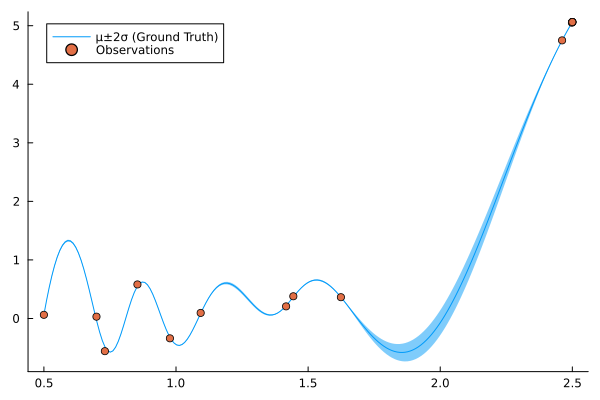

In [21]:
plot1D(sur; xmin=lbs[1], xmax=ubs[1], npts=200)
# plot!(domain, [testfn([x]) for x in domain], label="Underlying Function")

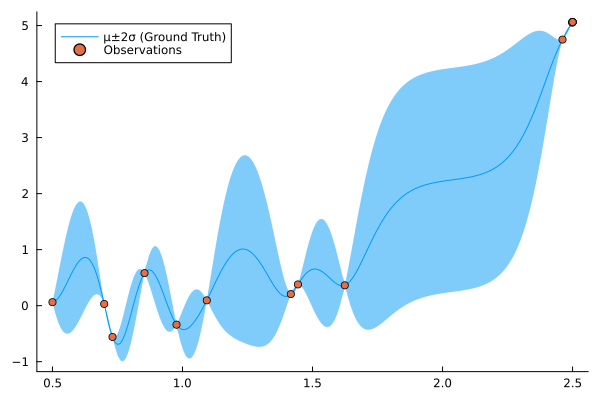

In [24]:
plot1D(optimize_hypers_optim(sur, kernel_matern52); xmin=lbs[1], xmax=ubs[1], npts=200)

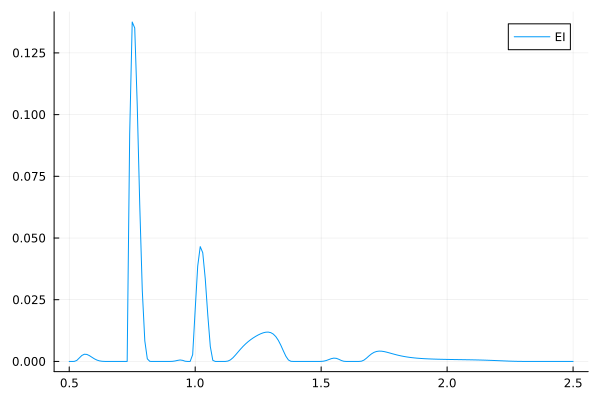

In [26]:
usur = optimize_hypers_optim(sur, kernel_matern52)
domain = lbs[1]:.01:ubs[1]
plot(domain, [usur([x]).EI for x in domain], label="EI")

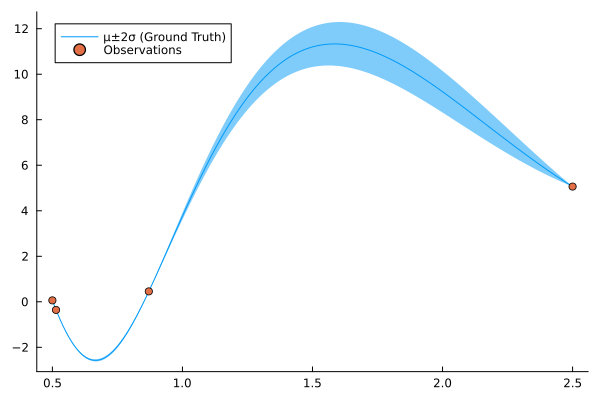

In [15]:
plot1D(sur_ei; xmin=lbs[1], xmax=ubs[1], npts=200)

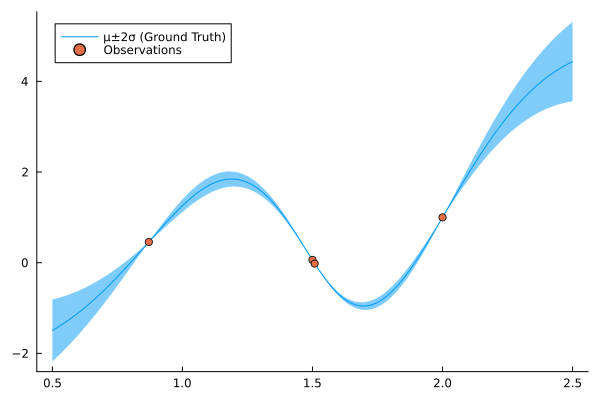

In [16]:
plot1D(sur_poi; xmin=lbs[1], xmax=ubs[1], npts=200)

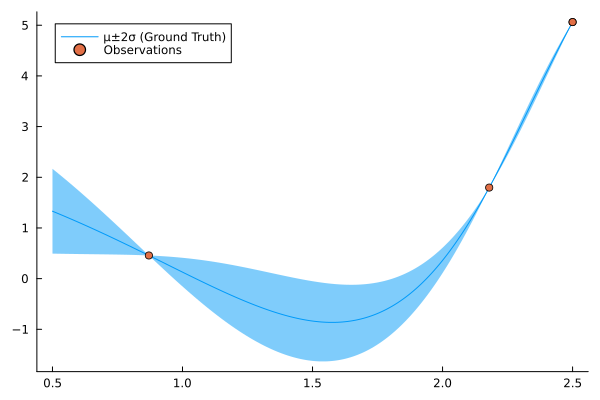

In [17]:
plot1D(sur_ucb; xmin=lbs[1], xmax=ubs[1], npts=200)